In [1]:
import math
import scipy
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy import optimize
from tqdm import trange, tqdm
from matplotlib import animation

from IPython.display import clear_output

In [2]:
target_filename = "woman.jpg"
source_filename = "chameleon.jpg"
target_img = Image.open("../inputs/" + target_filename)
source_img = Image.open("../inputs/" + source_filename)
source_img = source_img.resize(target_img.size)

In [3]:
target_arr = np.array(target_img)
source_arr = np.array(source_img)

d0, d1, _ = source_arr.shape
source_arr = source_arr[:d0//20*20, :d1//20*20,:]
target_arr = target_arr[:d0//20*20, :d1//20*20,:]

In [4]:
def transfer_pixel(imgSrc, imgTar, B=25):
    if len(imgTar.shape) == 2:
        rows, cols = imgTar.shape
        ch = 1
        final_arr = np.full((rows, cols), 255, dtype=imgSrc.dtype)
    else:
        rows, cols, ch = imgTar.shape
        final_arr = np.full((rows, cols, ch), 255, dtype=imgSrc.dtype)
    
    r = rows // B
    c = cols // B
            
    cost_matrix = np.empty((r,c,r,c,ch))

    srcAvg = np.empty((r,c,ch))
    tarAvg = np.empty((r,c,ch))

    for i in range(r):
        for j in range(c):
            srcAvg[i,j] = np.average(imgSrc[i*B:i*B+B, j*B:j*B+B], axis=(0,1))
            tarAvg[i,j] = np.average(imgTar[i*B:i*B+B, j*B:j*B+B], axis=(0,1))

    for i in range(r):
            for j in range(c):
                cost_matrix[i,j] = tarAvg[i,j] -  srcAvg

    cost_matrix = np.linalg.norm(cost_matrix, axis=-1)


    temp = cost_matrix.reshape(r, c, r*c).transpose(2,0,1).reshape(r*c, r*c).transpose(1,0)
    _, col_ind = optimize.linear_sum_assignment(temp)

    coords = col_ind.reshape(r,c)

    for i in range(r):
        for j in range(c):
            temp = coords[i,j]
            i2 = temp // c
            j2 = temp % c
            
            final_arr[i*B:i*B+B, j*B:j*B+B] = imgSrc[i2*B:i2*B+B, j2*B:j2*B+B].copy()
    
    return coords, final_arr

In [5]:
selected_srouce_arr = source_arr[650:700, 450:500]
selected_target_arr = target_arr[600:650, 450:500]

selected_srouce_arr_mean = selected_srouce_arr.mean(axis=(0, 1))
selected_target_arr_mean = selected_target_arr.mean(axis=(0, 1))
selected_srouce_arr_normalized = selected_srouce_arr - selected_srouce_arr_mean
selected_target_arr_normalized = selected_target_arr - selected_target_arr_mean

_, final_arr = transfer_pixel(selected_srouce_arr, selected_target_arr, B=1)
_, final_arr_normalized = transfer_pixel(selected_srouce_arr_normalized, selected_target_arr_normalized, B=1)

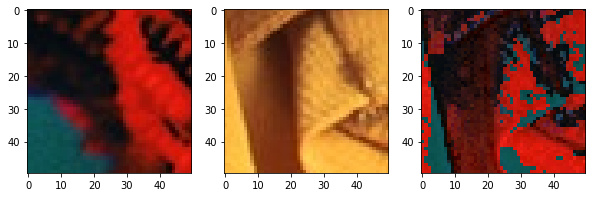

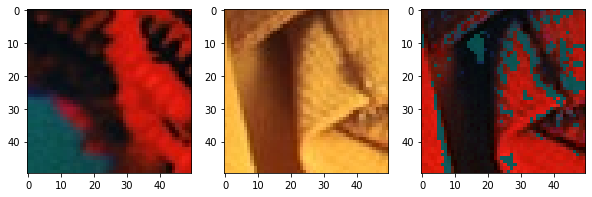

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(selected_srouce_arr)

plt.subplot(1, 3, 2)
plt.imshow(selected_target_arr)

plt.subplot(1, 3, 3)
plt.imshow(final_arr)
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow((selected_srouce_arr_normalized + selected_srouce_arr_mean) / 255)

plt.subplot(1, 3, 2)
plt.imshow((selected_target_arr_normalized + selected_target_arr_mean) / 255)

plt.subplot(1, 3, 3)
plt.imshow((final_arr_normalized + selected_srouce_arr_mean) / 255)
plt.show()

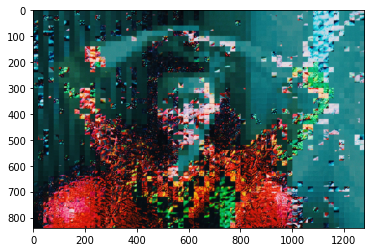

In [7]:
_, final_arr_block = transfer_pixel(source_arr, target_arr, B=20)
plt.imsave("../outputs/3/before_improved_block20.png", np.array(final_arr_block, dtype=np.uint8))
plt.imshow(final_arr_block)
plt.show()

In [8]:
def transfer_pixel_improved(source_arr, target_arr, block_size=30, stride=None):
    if not stride:
        stride = block_size

    final_arr = np.array(source_arr, dtype=np.float64)
    target_arr = np.array(target_arr, dtype=np.float64)

    for i in range(0, target_arr.shape[0] - block_size + 1, stride):
        for j in trange(0, target_arr.shape[1] - block_size + 1, stride):
            srcBlock = final_arr [i:i+block_size, j:j+block_size, :]
            trgBlock = target_arr[i:i+block_size, j:j+block_size, :]

            ms = srcBlock.mean(axis=(0, 1))
            srcBlock = srcBlock - ms

            mt = trgBlock.mean(axis=(0, 1))
            trgBlock = trgBlock - mt

            _coords, block = transfer_pixel(srcBlock, trgBlock, B=1)
            final_arr[i:i+block_size, j:j+block_size, :] = block + ms

        clear_output()
        plt.figure(figsize=(10, 10))
        plt.imshow(final_arr / 255)
        plt.show()
    
    return final_arr

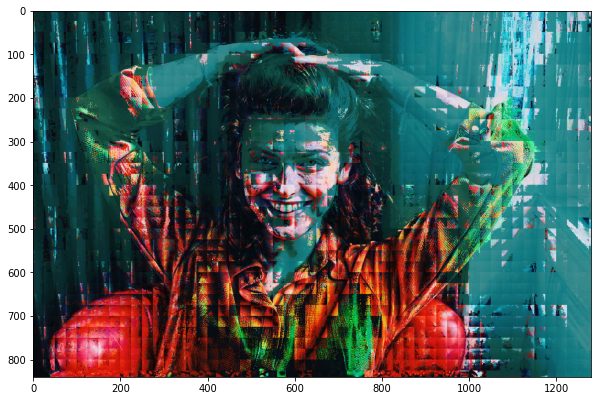

In [9]:
improved_25X25 = transfer_pixel_improved(final_arr_block, target_arr, block_size=25)
plt.imsave("../outputs/3/improved_block25_stride25.png", np.array(improved_25X25, dtype=np.uint8))

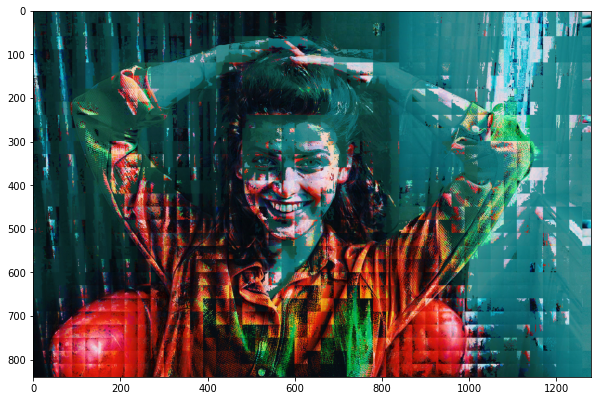

In [10]:
improved_30X30 = transfer_pixel_improved(final_arr_block, target_arr, block_size=30)
plt.imsave("../outputs/3/improved_block30_stride30.png", np.array(improved_30X30, dtype=np.uint8))

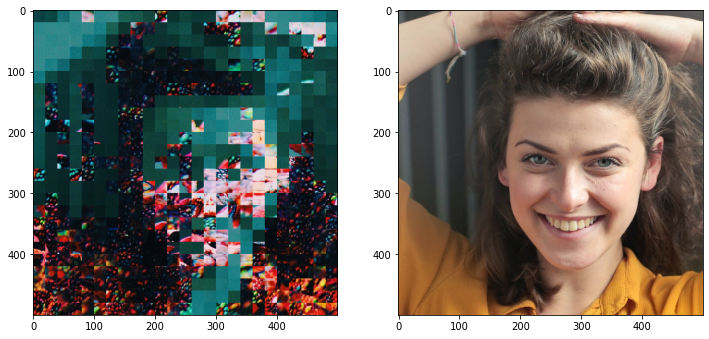

In [11]:
sub_final_arr_block = final_arr_block[100:600, 300:800, :]
sub_target_arr      = target_arr     [100:600, 300:800, :]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(sub_final_arr_block)

plt.subplot(1, 2, 2)
plt.imshow(sub_target_arr)

plt.show()

In [14]:
plt.imsave("../outputs/3/before_sub_source.png", np.array(sub_final_arr_block, dtype=np.uint8))
plt.imsave("../outputs/3/before_sub_target.png", np.array(sub_target_arr, dtype=np.uint8))

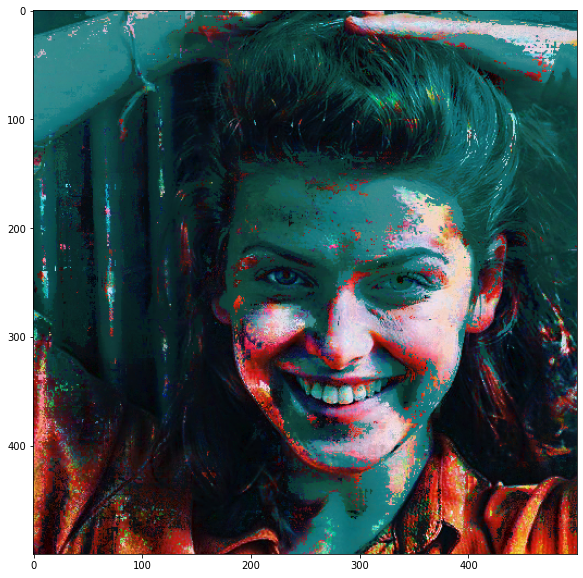

In [15]:
improved_25X25_5X5_sub = transfer_pixel_improved(sub_final_arr_block, sub_target_arr, block_size=25, stride=5)
plt.imsave("../outputs/3/improved_block25_stride5_sub.png", np.array(improved_25X25_5X5_sub, dtype=np.uint8))

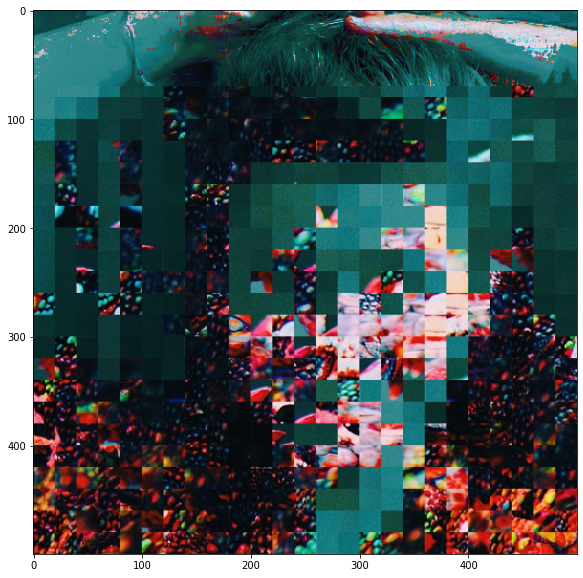

 64%|██████▍   | 61/95 [00:09<00:05,  6.10it/s]

In [16]:
improved_30X30_5X5_sub = transfer_pixel_improved(sub_final_arr_block, sub_target_arr, block_size=30, stride=5)
plt.imsave("../outputs/3/improved_block30_stride5_sub.png", np.array(improved_30X30_5X5_sub, dtype=np.uint8))

In [ ]:
improved_30X30_5X5 = transfer_pixel_improved(final_arr_block, target_arr, block_size=30, stride=5)
plt.imsave("../outputs/3/improved_block30_stride5.png", np.array(improved_30X30_5X5, dtype=np.uint8))